## Example 5.
### Sensitivity of hydraulic head at a point to a <font color='blue'>Neumann BC flux</font> under steady state flow conditions

## 0. Forward model
<br>
Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d^2h}{dx^2}=0\cr
\cr\end{align}$

Boundary conditions:

$\begin{align}
\quad\quad q(x)=q_{\Gamma_2}\ ,\quad\quad\quad\quad\quad x=0=\Gamma_2\cr
\end{align}$

$\begin{align}
\quad\quad h(x)=h_{\Gamma_1}\ ,\quad\quad\quad\quad\quad x=L=\Gamma_1\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\cr\end{align}$

Spatial derivatives from differentiation:

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

In [113]:
from IPython.display import HTML, display
def set_background(color):
    script = (
        "var cell = this.closest('.code_cell');"
        "var editor = cell.querySelector('.input_area');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)").format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

In [114]:
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)

import numpy as np

K, b, L, BC1h, BC2q, ocol = 10., 10., 10000., 0., 0.5, 5000
X = np.arange(L)

## 1. Direct sensitivity
$\begin{align}\cr
\quad\quad\rm{Not\ available}
\cr\cr\end{align}$

## 2. Perturbation sensitivity
$\begin{align}\cr
\frac{\partial h(x')}{\partial q_{\Gamma_2}}\approx\frac{h(x,q_{\Gamma_2}+\Delta q_{\Gamma_2})-h(x,q_{\Gamma_2})}{\Delta q_{\Gamma_2}}\;
\cr\cr\end{align}$

### 2a. Analytical
$\begin{align}\cr
\quad\quad\rm{Not\ available}
\cr\cr\end{align}$

### 2b. Semi-analytical

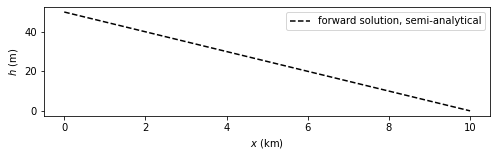

In [116]:
from os import getcwd, chdir
cwd = getcwd()
chdir(r'../../timml')
import timml
chdir(cwd)

dpar = 1e-4
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.LineSink1D(M0, xls=0, sigls=-BC2q/5000.)
timml.HeadLineSink1D(M0, xls=L, hls=0.)
M0.solve(silent=True)
H0 = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend();

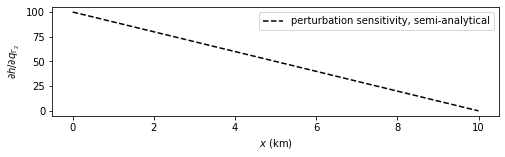

In [117]:
M1 = timml.Model3D(kaq=K, z=[0., -b])
timml.LineSink1D(M1, xls=0, sigls=-BC2q/5000.-BC2q/5000.*dpar)
timml.HeadLineSink1D(M1, xls=L, hls=0.)
M1.solve(silent=True)
H1 = M1.headalongline(X, 0.).flatten()
dhdBC2q = (H1-H0)/(BC2q*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdBC2q, 'k--', mfc='none', label='perturbation sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial q_{\Gamma_2}$')
plt.legend();

In [118]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC2q[ocol])

50.010000


### 2c. Numerical

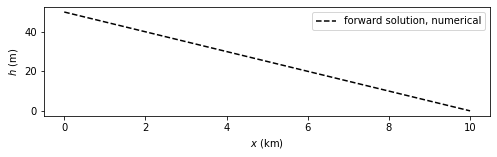

In [119]:
import flopy

nrow, ncol = 1, int(L)
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=nrow, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, 0, BC2q]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
H0 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., H0, 'k--', mfc='none', label='forward solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel('$h$ (m)')
plt.legend();

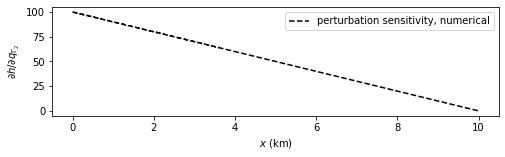

In [120]:
M1 = M0
flopy.modflow.ModflowWel(M1, stress_period_data={0: [0, 0, 0, BC2q+BC2q*dpar]})
M1.write_input()
success, buff = M1.run_model(silent=True)
H1 = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
dhdBC2q = (H1-H0)/(BC2q*dpar)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., dhdBC2q, 'k--', mfc='none', label='perturbation sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial q_{\Gamma_2}}$')
plt.legend();

In [121]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC2q[ocol])

49.972534


## 3. Adjoint sensitivity

<br>
    
$\begin{align}
\quad\quad \frac{\partial h(x')}{\partial q_{\Gamma_2}}=\oint\limits_{\Gamma_2}\psi^*_1(x)\; dx\ =\ \psi^*_1(\Gamma_2)
\cr\end{align}$

Governing equation:

$\begin{align}
\quad\quad K\ b\ \frac{d\psi^*_1}{dx}+\frac{1}{2\ K\ b}\delta(x-x')=0\cr
\cr\end{align}$

Boundary conditions: 

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\quad\quad\quad\quad\quad x=0=\Gamma_{1_0}\cr
\end{align}$

$\begin{align}
\quad\quad \psi^*_1(x)=0\ ,\quad\quad\quad\quad\quad x=L=\Gamma_{1_L}\cr
\cr\end{align}$

Closed-form solution:

$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

### 3a. Analytical
$\begin{align}
\quad\quad\rm{Not\ available}
\cr\end{align}$

### 3b. Semi-analytical

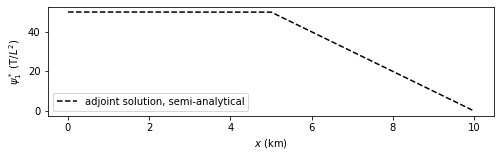

In [122]:
M0 = timml.Model3D(kaq=K, z=[0., -b])
timml.ImpLineDoublet1D(M0, xld=0.)
timml.HeadLineSink1D(M0, xls=L,  hls=0.)
timml.LineSink1D(M0, xls=float(ocol), sigls=-1.)
M0.solve(silent=True)
A = M0.headalongline(X, 0.).flatten()

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

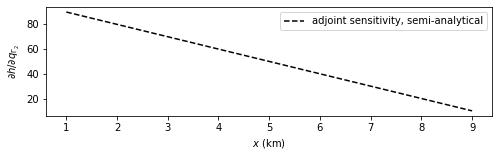

In [123]:
dhdBC2q = np.empty(0)
for xp in X[::1000]:
    M0 = timml.Model3D(kaq=K, z=[0., -b])
    timml.ImpLineDoublet1D(M0, xld=0.)
    timml.HeadLineSink1D(M0, xls=L, hls=0.)
    timml.LineSink1D(M0, xls=xp, sigls=-1.)
    M0.solve(silent=True)
    A = M0.headalongline(X, 0.).flatten()  
    dhdBC2q = np.append(dhdBC2q, A[0])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X[::1000][1:]/1000., dhdBC2q[1:], 'k--', mfc='none', label='adjoint sensitivity, semi-analytical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial q_{\Gamma_2}$')
plt.legend();

In [124]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC2q[int(np.where(X[::1000]==float(ocol))[0])])

50.000000


### 3c. Numerical

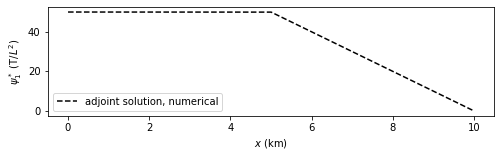

In [125]:
M0 = flopy.modflow.Modflow(modelname='model', exe_name='../mf2005.exe')
flopy.modflow.ModflowDis(M0, nlay=1, nrow=1, ncol=ncol, nper=1, delr=1., delc=1., top=0., botm=-b, steady=True, 
                         perlen=1., nstp=1)
flopy.modflow.ModflowBas(M0, ibound=np.hstack([np.ones([nrow, ncol-1], dtype=int), -1*np.ones([1,1])]), 
                         strt=BC1h*np.ones([nrow, ncol], dtype=float))
flopy.modflow.ModflowLpf(M0, hk=K, vka=-999., ss=-999., sy=-999., ipakcb=53)
flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, ocol, 1.]})
flopy.modflow.ModflowPcg(M0, hclose=1e-6, rclose=1e-6)
flopy.modflow.ModflowOc(M0, stress_period_data={(0,0): ['save head', 'save budget']})
M0.write_input()
success, buff = M0.run_model(silent=True)
A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplots(figsize=[8,2])
plt.plot(X/1000., A, 'k--', mfc='none', label='adjoint solution, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\psi^*_1$ (T/$L^2$)')
plt.legend(loc=3);

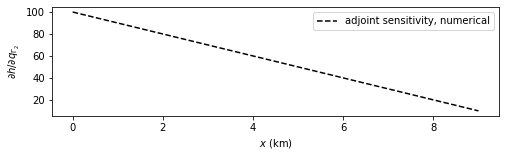

In [126]:
dhdBC2q = np.empty(0)
for oc,xp in enumerate(X[::1000]):
    M1 = M0
    flopy.modflow.ModflowWel(M0, stress_period_data={0: [0, 0, oc*1000, 1.]})
    M0.write_input()
    success, buff = M0.run_model(silent=True)
    A = flopy.utils.binaryfile.HeadFile('model.hds').get_data()[0,0,:]
    dhdBC2q = np.append(dhdBC2q, A[0])

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
f,s = plt.subplots(figsize=[8,2])
plt.plot(X[::1000]/1000., dhdBC2q, 'k--', mfc='none', label='adjoint sensitivity, numerical')
plt.xlabel('$x$ (km)')
plt.ylabel(r'$\partial h / \partial q_{\Gamma_2}$')
plt.legend();

In [127]:
set_background('rgba(0, 200, 0, 0.2)')
print('%.6f'% dhdBC2q[int(np.where(X[::1000]==float(ocol))[0])])

49.990002
